# Train-test of single PINN poisson

In [11]:
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jacobian, jit, vmap
import jax.numpy as np
import numpy as onp
import sys
from tqdm import tqdm
from utils import data_path
from base_network import neural_network
from poisson.poisson_utils import boundary_loss_factory, interior_loss_factory, crude_rel_L2
from jax.nn import sigmoid

In [12]:
file = data_path / "poisson_single_pinn_train.json"
file_test = data_path / "poisson_single_pinn_test.json"
activation = sigmoid

### Set model (FFNN)
xpinn = XPINN(file, activation)
model = neural_network(activation)
v_model = vmap(model, (None, 0))

In [13]:
### Set RHS
def eval(x):
    a = 0
    if 0.25<=x[0]<=0.75 and 0.25<=x[1]<=0.75:
        a=1
    return a

def f():
    points=xpinn.PINNs[0].interior
    f=onp.zeros_like(points)
    for i,point in enumerate(points):
        f[i] = eval(point)
    return np.array(f)

rhs = -f()

In [14]:
# Set losses
p0 = xpinn.PINNs[0]
p0.boundary_loss = boundary_loss_factory(p0, 0, weight = 20)
p0.interior_loss = interior_loss_factory(p0, rhs, weight = 1)
p0.create_loss()
xpinn.set_loss()


In [15]:
shapes = [[2, 20, 20, 20, 20, 20, 20, 20, 1]]
for pinn, shape in zip(xpinn.PINNs, shapes):
    exponential_decay = optax.exponential_decay(
        init_value=0.001,
        transition_steps=10000,
        transition_begin=15000,
        decay_rate=0.1,
        end_value=0.0000001,
    )
    optimizer = optax.adam(learning_rate=0.0008)

    pinn.init_params(shape, optimizer)

/Users/junmiaohu/Documents/UiO/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:24: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return scale * random.normal(
/Users/junmiaohu/Documents/UiO/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:26: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ), scale * random.normal(b_key, (n,), dtype=np.float64)


In [16]:
n_iter = 20000
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 20000: Total loss = 1.7122057676315308
10.00% iter = 2000 of 20000: Total loss = 0.19034183025360107
20.00% iter = 4000 of 20000: Total loss = 0.19000454246997833
30.00% iter = 6000 of 20000: Total loss = 0.18992142379283905
40.00% iter = 8000 of 20000: Total loss = 0.18990296125411987
50.00% iter = 10000 of 20000: Total loss = 0.18989264965057373
60.00% iter = 12000 of 20000: Total loss = 0.18988299369812012
70.00% iter = 14000 of 20000: Total loss = 0.18987324833869934
80.00% iter = 16000 of 20000: Total loss = 0.1898626685142517
90.00% iter = 18000 of 20000: Total loss = 0.1898500919342041
100.00% iter = 20000 of 20000: Total loss = 0.189834862947464


(1, 20000)
1.7122058
1.7122058


Text(0.5, 1.0, 'Loss per Pinn over 20000 epochs')

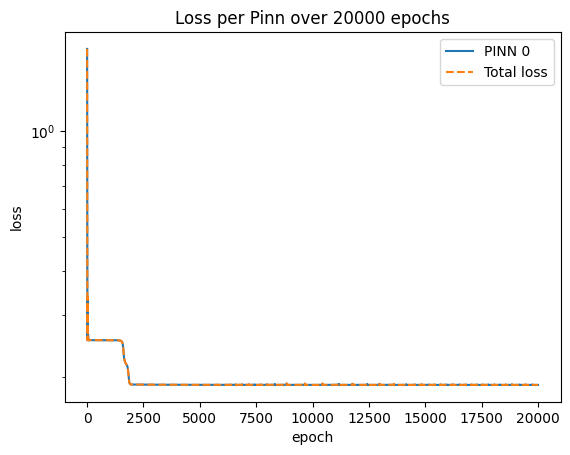

In [17]:
import matplotlib.pyplot as plt

a_losses = np.asarray(losses)
t_0 = 0
t = np.arange(t_0, n_iter)
print(a_losses.shape)
for i in range(2):
    print(a_losses[i,t_0])

for i in range(1):
    plt.plot(t, a_losses[i, t_0:], label=f"PINN {i}")
plt.plot(t, np.sum(a_losses, axis=0)[t_0:], "--", label="Total loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()
plt.title(f"Loss per Pinn over {n_iter} epochs")

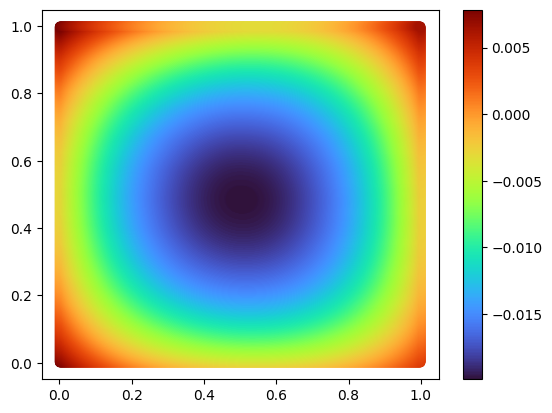

In [21]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
min_, max_ = total_pred.min(), total_pred.max()


for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="turbo")
    plt.clim(min_, max_)

plt.colorbar()